In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from Functionality import Reduce_numerical_columns,Reduce_text_change,Reduce_event,Reduce_activity,getX_Y,getModel,performCrossValidation,makePredictions,perfromGridSearch,performKfoldScore,Aggregation,ConcatAlongId
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
import re
import copy
import string
import seaborn as sns
import statistics
from sklearn.model_selection import KFold,train_test_split
import lightgbm as lgb
import tqdm
from collections import Counter
from collections import defaultdict

/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directories Where the data is present
train_logs_directory = os.path.join("Data","train_logs.csv")
train_scores_directory = os.path.join("Data","train_scores.csv")
test_logs_directory = os.path.join("Data","test_logs.csv")

# Loading Dataset

In [3]:
# following the naming convention that everything related
# to train will be followed by train_ and everything followed by test will be followed by test_
train_logs_df = pd.read_csv(train_logs_directory)
test_logs_df = pd.read_csv(test_logs_directory)
train_scores_df = pd.read_csv(train_scores_directory)

In [4]:
train_df = pd.merge(train_logs_df,train_scores_df,on = "id",how = "inner")
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


# Exploratory Data Analysis

In [5]:
# No null values are present
# train_logs_df.isnull().sum()

In [6]:
train_df.dtypes

id                  object
event_id             int64
down_time            int64
up_time              int64
action_time          int64
activity            object
down_event          object
up_event            object
text_change         object
cursor_position      int64
word_count           int64
score              float64
dtype: object

In [7]:
train_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [8]:
train_df["up_event"].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'm', 'Rightclick', 'i', 'o', 't', '=', 'a',
       'CapsLock', 'Control', 'c', 'v', '/', 'Delete', ':', 'z', '[', '$',
       '(', ')', '+', 'Home', 'End', '\\', 'Meta', '*', '&',
       'AudioVolumeMute', 'x', '!', 'Insert', 'MediaPlayPause', 'w',
       'NumLock', '%', 'V', 'b', '>', 'Alt', 'AudioVolumeUp',
       'ContextMenu', 'AudioVolumeDown', 'n', 'e', '<', 'PageDown', ']',
       'Middleclick', '@', 'F12', 'u', 'j', 's', '\x96', 'Dead', 'y', '{',
       'ScrollLock', '¿', 'p', 'Process', '}', 'MediaTrackPrevious',
       'MediaTrackNext', 'F3', '^', 'Unidentified', 'Cancel', 'h', '2',
       'd', 'r', '`', '\x9b', 'f', 'g', '#', '~', 'PageUp', 'l', 'T', 'A',
       'S', 'ModeChange', '_', 'Escape', 'F11', 'Unknownclick',
       'AltGraph', 'F10', 'F15', 'Clear', 'OS', 'C', 'Ä±', 'M', '|',
       'â\x80\x93', 

In [9]:
# Highly skewed dataset
train_df["activity"].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]',
       'Move From [669, 847] To [565, 743]',
       'Move From [1041, 1121] To [1496, 1576]',
       'Move From [1455, 1557] To [1323, 1425]',
       'Move From [2268, 2275] To [2247, 2254]',
       'Move From [213, 302] To [902, 991]',
       'Move From [0, 158] To [234, 392]',
       'Move From [460, 465] To [925, 930]',
       'Move From [810, 906] To [816, 912]',
       'Move From [186, 187] To [184, 185]',
       'Move From [140, 272] To [299, 431]',
       'Move From [114, 140] To [272, 298]',
       'Move From [1386, 1450] To [1445, 1509]',
       'Move From [442, 524] To [296, 378]',
       'Move From [408, 414] To [390, 396]',
       'Move From [1144, 1147] To [1142, 1145]',
       'Move 

In [10]:
train_df["activity"]

0          Nonproduction
1          Nonproduction
2          Nonproduction
3                  Input
4                  Input
               ...      
8405893    Nonproduction
8405894    Nonproduction
8405895          Replace
8405896    Nonproduction
8405897            Input
Name: activity, Length: 8405898, dtype: object

In [11]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [12]:
train_df["text_change"]

0          NoChange
1          NoChange
2          NoChange
3                 q
4                 q
             ...   
8405893    NoChange
8405894    NoChange
8405895      q => q
8405896    NoChange
8405897           .
Name: text_change, Length: 8405898, dtype: object

# Working on the essay part and adding more features

In [13]:
def EssayGenerator(temp_df):
    essay_text = ""
    

    for index,i in temp_df.iterrows():
    
        cursor_position = i["cursor_position"]
    
        if i["activity"] == "Input":
            essay_text = essay_text[:cursor_position - len(i["text_change"])] + i["text_change"] + essay_text[cursor_position - len(i["text_change"]):]
            continue
    
        if i["activity"] == "Replace":
            # cursor position is after the operation
            replace_text = i["text_change"].split(" => ") # replace_text = ["original word" , "newWord"]
            essay_text = essay_text[:cursor_position - len(replace_text[1])] + replace_text[1] + essay_text[cursor_position - len(replace_text[1]) + len(replace_text[0]):]
            continue

        if i["activity"] == "Remove/Cut":
            remove_word = i["text_change"]
            essay_text = essay_text[:cursor_position] + essay_text[cursor_position+ len(remove_word):]
            continue
    
        
        if i["activity"] == "Paste":
            text = i["text_change"]
            essay_text = essay_text[:cursor_position-len(text)] + text + essay_text[cursor_position - len(text):]
            continue
    
        if i["activity"].startswith("Move"):
            text = i["activity"]
            matches = re.findall(r'\[.*?\]', text)
            arrays = [eval(match) for match in matches]
    
            # Move the text from array[0] to array[1] postion 
            if arrays[0][0] < arrays[1][0]:
                # Here movement is done from the lower of the text to the higher part of the tex+t
                essay_text = essay_text[:arrays[0][0]] + essay_text[arrays[0][1] : arrays[1][0]] + essay_text[arrays[0][0] : arrays[0][1]] + essay_text[arrays[1][0]:]
            else:
                # Here movement is done from the higher end to the lower end 
                essay_text = essay_text[:arrays[1][0]] + essay_text[arrays[0][0]: arrays[0][1]] + essay_text[arrays[1][0]: arrays[0][0]] + essay_text[arrays[0][1]:]
            continue 
    return essay_text

def count_punctuations(sentence):
    punctuation_count = sum(1 for char in sentence if char in string.punctuation)
    return punctuation_count

In [83]:
def GetEssay(train_logs_df,train_postprocessed_df):
    # temp_df = copy.deepcopy(train_logs_df)
    # essay = temp_df.groupby("id").apply(lambda x : EssayGenerator(x))
    # final_df = pd.DataFrame(essay).reset_index()
    # final_df.columns = ["_id","essay"]
    temp_df = copy.deepcopy(train_logs_df)
    grouped_df = temp_df.groupby("id")

    
    if not os.path.exists("essay.csv"):
        # Initialize tqdm with the total number of groups (number of unique "id"s)
        with tqdm.tqdm(total=len(grouped_df), desc="Processing groups") as pbar:
            def process_group(group):
                essay_result = EssayGenerator(group)
                pbar.update(1)  # Update the progress bar for each processed group
                return essay_result
        
            essay = grouped_df.apply(process_group)
        # essay = temp_df.groupby("id").apply(lambda x : EssayGenerator(x))
        final_df = pd.DataFrame(essay).reset_index()
        final_df.columns = ["_id","essay"]
        final_df.to_csv("essay.csv",index = False)
    else:
        final_df = pd.read_csv("essay.csv")
    
    essay_df = copy.deepcopy(final_df)
    essay_df.rename(columns={"_id": "id"}, inplace=True)
        
    # final_df = pd.merge(final_df,train_postprocessed_df,on = "_id",how = "inner")
    

    #Adding essay Level features
    
    # {'+', '&', '\x99', '[', '~', '|', 'e', '\\', '\x96', '_', '.', '%', 'o', '\x86', '¡', 'g', '@', 'Ë', 
    #  'h', 'C', '$', 'n', '<', 'Ä', ']', '-', '*', 'â', '^', '`', '=', '·', '#', ',', '(', 'Å', 'a', '\xa0', '\x92', 
    #  '\x9b', '\x93', '?', 'N', '\x80', '\x97', ';', '"', ')', '\x9f', "'", '/', '\x94', 'ä', ':', '}', ' ', '!', '{', '¿', '>', '\n', 'q', '±', 'Â', '´'}
    
    final_df["number_of_commas_in_essay"] = final_df["essay"].str.count(",")
    final_df["number_of_exclamation_in_essay"] = final_df["essay"].str.count("!")
    final_df["number_of_questionmark_in_essay"] = final_df["essay"].str.count("\?")
    final_df["number_of_fullstops_in_essay"] = final_df["essay"].str.count(".")
    final_df["number_of_singlequotes_in_essay"] = final_df["essay"].str.count("'")
    final_df["number_of_doublequotes_in_essay"] = final_df["essay"].str.count('"')
    final_df["number_of_semicolon_in_essay"] = final_df["essay"].str.count(';')
    final_df["number_of_colon_in_essay"] = final_df["essay"].str.count(':')


    # return final_df

    #Adding the sentence length
    sentence_level_features = {
        "number_of_sentence":[],
        "max_length_sentence":[],
        "min_length_sentence":[],
        "max_punchuation_sentence":[],
        "max_number_of_spaces_per_sentence" : [],
        "min_number_of_spaces_per_sentence" : [],
        "average_length_sentence": [],
        "std_length_sentence" : [],
        "max_number_of_words_sentence":[],
        "min_number_of_words_sentence":[],
        "sum_length_of_sentence" : [],
        "words_to_sentences_ratio" : [],
        "sentence_nearness_ratio_max":[], # taking ration of len(sentence1)/len(sentence2)
        "sentence_nearness_ratio_sum" : [],
        "sentence_nearness_ratio_min":[],
        
    }
    for row in final_df["essay"].apply(lambda x: re.split('\\.|\\?|\\!',x)):
        # Iterating through the sentences rowise
        row = [x.replace("\n","").strip() for x in row]
        sentence_level_features["number_of_sentence"].append(len(row))
        sentence_lengths = [len(s) for s in row]
        word_counts = [len(s.split(" ")) for s in row]
        sentence_level_features["max_length_sentence"].append(max(sentence_lengths))
        sentence_level_features["min_length_sentence"].append(min(sentence_lengths))
        sentence_level_features["max_number_of_spaces_per_sentence"].append(len(max(row,key = lambda s : len(s.split()))))
        sentence_level_features["min_number_of_spaces_per_sentence"].append(len(min(row,key = lambda s : len(s.split())))) 
        sentence_level_features["max_punchuation_sentence"].append(len(max(row,key = lambda s : count_punctuations(s))))
        sentence_level_features["average_length_sentence"].append(sum(sentence_lengths)/len(sentence_lengths))
        if len(sentence_lengths) >= 2:
            sentence_level_features["std_length_sentence"].append(statistics.stdev(sentence_lengths))
        else:
            sentence_level_features["std_length_sentence"].append(0)

        sentence_level_features["max_number_of_words_sentence"].append(max(word_counts))
        sentence_level_features["min_number_of_words_sentence"].append(min(word_counts))
        sentence_level_features["sum_length_of_sentence"].append(sum(len(x) for x in row))

        sentence_level_features["words_to_sentences_ratio"].append(sum(word_counts)/(sum(sentence_lengths)+1))

        sentence_ratio = [sentence_lengths[i-1]/(sentence_lengths[i]+1) for i in range(1,len(row))]
        if len(sentence_ratio) > 1:
            sentence_level_features["sentence_nearness_ratio_max"].append(max(sentence_ratio))
            sentence_level_features["sentence_nearness_ratio_sum"].append(sum(sentence_ratio))
            sentence_level_features["sentence_nearness_ratio_min"].append(min(sentence_ratio))

        else:
            sentence_level_features["sentence_nearness_ratio_max"].append(0)
            sentence_level_features["sentence_nearness_ratio_sum"].append(0)
            sentence_level_features["sentence_nearness_ratio_min"].append(0)

    sentence_level_df = pd.DataFrame(sentence_level_features)
    final_df = pd.concat([final_df,sentence_level_df],axis = 1)

    # Adding word level features 
    word_level_features = {
        "max_word_length" : [],
        "min_word_length" : [],
        "average_word_length":[],
        "number_of_words" : [],
        "number_of_1_character_word" : [],
        "number_of_2_character_word" : [],
        "number_of_3_character_word" : [],
        "number_of_4_character_word" : [],
        "number_of_5_character_word" : [],
        "number_of_6_character_word" : [],
        "number_of_7_character_word" : [],
        "std_of_word_length" : [],
        
    }
    for row in final_df["essay"].str.split():
        if len(row) == 0:
            for key,value in word_level_features.items():
                word_level_features[key].append(0)
            continue
            
        row = [''.join(char for char in s if char not in string.punctuation) for s in row]
            
        word_level_features["max_word_length"].append(len(max(row,key = lambda s: len(s))))
        word_level_features["min_word_length"].append(len(min(row,key = lambda s: len(s))))
    
        average = sum([len(s) for s in row]) / len(row)

        number_of_character_word = [len(s) for s in row]
    
        word_level_features["average_word_length"].append(average)
        word_level_features["number_of_words"].append(len(row))
        word_level_features["number_of_1_character_word"].append(number_of_character_word.count(1))
        word_level_features["number_of_2_character_word"].append(number_of_character_word.count(2))
        word_level_features["number_of_3_character_word"].append(number_of_character_word.count(3))
        word_level_features["number_of_4_character_word"].append(number_of_character_word.count(4))
        word_level_features["number_of_5_character_word"].append(number_of_character_word.count(5))
        word_level_features["number_of_6_character_word"].append(number_of_character_word.count(6))
        word_level_features["number_of_7_character_word"].append(sum(i for i in number_of_character_word if i >= 7))
        if len(number_of_character_word) > 2:
            word_level_features["std_of_word_length"].append(statistics.stdev(number_of_character_word))
        else:
            word_level_features["std_of_word_length"].append(0)




    word_level_df = pd.DataFrame(word_level_features)
    final_df = pd.concat([final_df,word_level_df],axis = 1)

    # Adding paragraph level features
    paragraph_level_features = {
        "number_of_paragraphs" : [],
        "max_length_paragraphs" : [],
        "min_length_paragraphs" : [],
        "max_number_of_spaces_paragraph" : [],
        "max_number_of_sentence_paragraph" : [],
        "min_number_of_sentence_paragraph" : [],
        "average_number_of_sentence_paragraph" : [],
        "first_para_last_para_ratio" : [],        # first para last para ration 
        "first_and_last_para_to_rest_para_length_ratio" : [],        # first + last para length body length(para) ration
        "max_number_of_words_per_paragraph" : [],
        "min_number_of_words_per_paragraph" : [],
        "std_number_of_words_paragraphs" : [],
        "sentences_paragraph_ration" : [],
        "words_per_paragraph_ratio" : [],
        "paragraph_importance_sum" : [], # position * number_of_words/total_length
        "paragraph_importance_max" : [], 
        "paragraph_importance_min" : [], 
    }
    for row in final_df["essay"].str.split("\n"):
        non_empty_lines = [line for line in row if line]
        number_of_sentences = [len(list(re.split(r'[.!?]', s))) for s in non_empty_lines]
        number_of_words = [len(list(s.split())) for s in row]
        paragraph_importance = [i * number_of_words[i]/(len(non_empty_lines)+1) for i in range(len(number_of_words))]
        
        paragraph_level_features["number_of_paragraphs"].append(len(non_empty_lines))
        paragraph_level_features["max_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["min_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["max_number_of_spaces_paragraph"].append(len(max(non_empty_lines,key = lambda s: len(s.split())).split())-1)
        paragraph_level_features["max_number_of_sentence_paragraph"].append(max(number_of_sentences))
        paragraph_level_features["min_number_of_sentence_paragraph"].append(min(number_of_sentences))
        paragraph_level_features["average_number_of_sentence_paragraph"].append(sum(number_of_sentences)/len(number_of_sentences))
        paragraph_level_features["max_number_of_words_per_paragraph"].append(max(number_of_words))
        paragraph_level_features["min_number_of_words_per_paragraph"].append(min(number_of_words))
        if len(number_of_words) >= 2:
            paragraph_level_features["std_number_of_words_paragraphs"].append(statistics.stdev(number_of_words))
        else:
            paragraph_level_features["std_number_of_words_paragraphs"].append(0)
        paragraph_level_features["sentences_paragraph_ration"].append(sum(number_of_sentences)/(len(non_empty_lines)+1))
        paragraph_level_features["words_per_paragraph_ratio"].append(sum(number_of_words)/(len(non_empty_lines)+1))
        paragraph_level_features["paragraph_importance_sum"].append(sum(paragraph_importance))
        paragraph_level_features["paragraph_importance_max"].append(max(paragraph_importance))
        paragraph_level_features["paragraph_importance_min"].append(min(paragraph_importance))

        lengths_of_paragraphs = [len(x) for x in non_empty_lines]
        
        if len(non_empty_lines) >= 2:
            paragraph_level_features["first_para_last_para_ratio"].append(lengths_of_paragraphs[0]/(lengths_of_paragraphs[-1]+1))
            paragraph_level_features["first_and_last_para_to_rest_para_length_ratio"].append((lengths_of_paragraphs[0] + lengths_of_paragraphs[-1])/(sum(lengths_of_paragraphs[1:-1])+1.0))
        else:
            paragraph_level_features["first_and_last_para_to_rest_para_length_ratio"].append(0)
            paragraph_level_features["first_para_last_para_ratio"].append(0)
        

    paragraph_level_df = pd.DataFrame(paragraph_level_features)
    final_df = pd.concat([final_df,paragraph_level_df],axis = 1)


    def q1(x):
        return x.quantile(0.25)
    def q3(x):
        return x.quantile(0.75)

    AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', 'median', 'skew', 'sum']

    def split_essays_into_words(df):
        essay_df = df
        essay_df['word'] = essay_df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
        essay_df = essay_df.explode('word')
        essay_df['word_len'] = essay_df['word'].apply(lambda x: len(x))
        essay_df = essay_df[essay_df['word_len'] != 0]
        return essay_df
    
    def compute_word_aggregations(word_df):
        word_agg_df = word_df[['id','word_len']].groupby(['id']).agg( AGGREGATIONS )
        word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
        word_agg_df['id'] = word_agg_df.index
        for word_l in [5, 6, 7, 8, 9, 10, 11, 12]:
            word_agg_df[f'word_len_ge_{word_l}_count'] = word_df[word_df['word_len'] >= word_l].groupby(['id']).count().iloc[:, 0]
            word_agg_df[f'word_len_ge_{word_l}_count'] = word_agg_df[f'word_len_ge_{word_l}_count'].fillna(0)
        word_agg_df = word_agg_df.reset_index(drop=True)
        return word_agg_df
    
    def split_essays_into_sentences(df):
        essay_df = df
        #essay_df['id'] = essay_df.index
        essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
        essay_df = essay_df.explode('sent')
        essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
        # Number of characters in sentences
        essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
        # Number of words in sentences
        essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
        essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
        return essay_df
    
    def compute_sentence_aggregations(df):
        sent_agg_df = pd.concat(
            [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
        )
        sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
        sent_agg_df['id'] = sent_agg_df.index

        # New features intoduced here: https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline-v2
        for sent_l in [50, 60, 75, 100]:
            sent_agg_df[f'sent_len_ge_{sent_l}_count'] = df[df['sent_len'] >= sent_l].groupby(['id']).count().iloc[:, 0]
            sent_agg_df[f'sent_len_ge_{sent_l}_count'] = sent_agg_df[f'sent_len_ge_{sent_l}_count'].fillna(0)
    
        sent_agg_df = sent_agg_df.reset_index(drop=True)
        sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
        sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
        return sent_agg_df

    def split_essays_into_paragraphs(df):
        essay_df = df
        #essay_df['id'] = essay_df.index
        essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
        essay_df = essay_df.explode('paragraph')
        # Number of characters in paragraphs
        essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x))
        # Number of words in paragraphs
        essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
        essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
        return essay_df

    def compute_paragraph_aggregations(df):
        paragraph_agg_df = pd.concat(
            [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
        )
        paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
        paragraph_agg_df['id'] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
        paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
        return paragraph_agg_df
    
    train_word_agg_df = compute_word_aggregations(split_essays_into_words(essay_df))
    train_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(essay_df))
    train_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(essay_df))
    
    final_df = pd.concat([final_df,train_word_agg_df,train_sent_agg_df,train_paragraph_agg_df],axis = 1)
    final_df.drop(["id"],inplace = True,axis = 1)
    return final_df

In [84]:
# final_df = GetEssay(train_logs_df,None)

In [85]:
# sorted(list(final_df.columns))

In [90]:
# Code for creating these features comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf
def addLogs(train_logs,test_logs):
    data = []
    
    for logs in [train_logs, test_logs]:
        logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
        logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000
    
        group = logs.groupby('id')['time_diff']
        largest_lantency = group.max()
        smallest_lantency = group.min()
        median_lantency = group.median()
        initial_pause = logs.groupby('id')['down_time'].first() / 1000
        pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
        pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
        pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
        pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
        pauses_3_sec = group.apply(lambda x: (x > 3).sum())
    
        data.append(pd.DataFrame({
            'id': logs['id'].unique(),
            'largest_lantency': largest_lantency,
            'smallest_lantency': smallest_lantency,
            'median_lantency': median_lantency,
            'initial_pause': initial_pause,
            'pauses_half_sec': pauses_half_sec,
            'pauses_1_sec': pauses_1_sec,
            'pauses_1_half_sec': pauses_1_half_sec,
            'pauses_2_sec': pauses_2_sec,
            'pauses_3_sec': pauses_3_sec,
        }).reset_index(drop=True))
    
    train_eD592674, test_eD592674 = data
    train_eD592674.drop("id",inplace = True,axis = 1)
    test_eD592674.drop("id",inplace = True,axis = 1)
    
    return train_eD592674,test_eD592674

In [91]:
# The following code comes almost Abdullah's notebook: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Abdullah's code is based on work shared in previous notebooks (e.g., https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline)

class PostAggregation:

    def __init__(self, seed):
        self.seed = seed
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
                       'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                             '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

        self.idf = defaultdict(float)
        
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm.tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm.tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm.tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm.tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):

        feats = pd.DataFrame({'id': df['id'].unique().tolist()})

        print("Engineering time data")
        for gap in self.gaps:
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering statistical summaries for features")
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            # ('action_time',  [pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew']),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew']),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew'])
            ])

        pbar = tqdm.tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [92]:
# postAggregation = PostAggregation(seed=42)
# train_feats = postAggregation.make_feats(train_logs_df)
# test_feats = postAggregation.make_feats(test_logs_df)
# nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
# train_feats = train_feats.drop(columns=nan_cols)
# test_feats = test_feats.drop(columns=nan_cols)

# Data Filteration

In [93]:
# Splitting the dataset between the categorical and numerical values
num_attributes = ["id","event_id","down_time","up_time","action_time","cursor_position","word_count"]
cat_attributes = ["activity","down_event","up_event","text_change"]

In [94]:
processing = ColumnTransformer([
    ("RemoveId",make_pipeline(Reduce_numerical_columns()),num_attributes),
     ("ValueSum",make_pipeline(Reduce_text_change()),["text_change","id"]),
    # ("RemoveMove",make_pipeline(Reduce_activity(),OneHotEncoder(sparse_output=False)),["activity"]),
    # ("ReduceUpEvents",make_pipeline(Reduce_event(name = "Up")),["up_event"]),
    ("ReduceDownEvents",make_pipeline(Reduce_event(name = "Down")),["down_event"]),   
],
    # remainder="passthrough"
)

In [95]:
train_logs_df,y = getX_Y(train_logs_df,train_scores_df,perform_harmonic_variation=False,aggregation=True)
# train_processed_numpy = processing.fit_transform(train_logs_df)
# test_processed_numpy = processing.transform(test_logs_df)
train_postprocessed_df = pd.DataFrame(processing.fit_transform(train_logs_df),columns=processing.get_feature_names_out())
test_postprocessed_df = pd.DataFrame(processing.transform(test_logs_df),columns=processing.get_feature_names_out())

In [96]:
post_processing = make_pipeline(Aggregation())

In [97]:

# Concating the columns 
train_postprocessed_df = ConcatAlongId(train_postprocessed_df,train_logs_df)
test_postprocessed_df = ConcatAlongId(test_postprocessed_df,test_logs_df)

# Aggreagating the columns for both train and test
# train_postprocessed_numpy = post_processing.fit_transform(train_postprocessed_df)
train_postprocessed_df = pd.DataFrame(post_processing.fit_transform(train_postprocessed_df),columns=post_processing.get_feature_names_out())
# test_postprocessed_numpy = post_processing.transform(test_postprocessed_df)
test_postprocessed_df = pd.DataFrame(post_processing.transform(test_postprocessed_df),columns=post_processing.get_feature_names_out())

# # Adding the essay level features 
train_postprocessed_df = GetEssay(train_logs_df,train_postprocessed_df)
test_postprocessed_df = GetEssay(test_logs_df,test_postprocessed_df)

# Remvoing id and essay
train_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)
test_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)

#Convert each of types to float
train_postprocessed_df = train_postprocessed_df.astype(float)
test_postprocessed_df = test_postprocessed_df.astype(float)

/Users/kirtankanani/Desktop/Python/kaggle/linking-writing-processes-to-writing-quality/Functionality/Transformations.py:252: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  final_df3.drop("id", inplace=True, axis=1)
/Users/kirtankanani/Desktop/Python/kaggle/linking-writing-processes-to-writing-quality/Functionality/Transformations.py:252: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  final_df3.drop("id", inplace=True, axis=1)


In [98]:
# AddExtra features 
#TODO: create post aggregation pipeline
postAggregation = PostAggregation(seed=42)
train_feats = postAggregation.make_feats(train_logs_df)
test_feats = postAggregation.make_feats(test_logs_df)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)
train_feats.drop(["id"],inplace = True,axis = 1)
test_feats.drop(["id"],inplace = True,axis = 1)

train_logs_level_feature_df,test_logs_level_feature = addLogs(train_logs_df,test_logs_df)

train_postprocessed_df = pd.concat([train_postprocessed_df,train_feats,train_logs_level_feature_df],axis = 1)
test_postprocessed_df = pd.concat([test_postprocessed_df,test_feats,test_logs_level_feature],axis = 1)


Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 31/31 [01:04<00:00,  2.08s/it, column=word_count_change100, method=skew]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 13416.50it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 13696.97it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 14208.43it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 14566.56it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 13600.59it/s]


Engineering input words data
Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 31/31 [00:00<00:00, 128.26it/s, column=word_count_change100, method=skew]         


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 38956.38it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 83330.54it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<00:00, 124583.29it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 119837.26it/s]
/opt/miniconda3/envs/kaggle/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 131072.00it/s]


Engineering input words data
Engineering ratios data


In [ ]:
train_processed_df = ConcatAlongId(train_processed_df,train_logs_df)

In [ ]:
train_processed_df

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    final = []
    sum = 0
    for i in temp_df["Down_Punchuations"]:
        sum += i
        final.append(sum)
    plt.plot(temp_df["down_time"],final)
    k+=1
    if k == 100:
        break
plt.show()
    

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.scatter(temp_df["down_time"],temp_df["Down_Punchuations"])
    k+=1
    if k == 1:
        break
plt.show()

In [ ]:
# len(train_processed_df)

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["word_count"])
    k+=1
    if k == 100:
        break
plt.show()

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["cursor_position"])
    k+=1
    if k == 100:
        break
plt.show()

In [ ]:
k = 0
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    plt.plot(temp_df["down_time"],temp_df["word_count"])
    # k+=1
    # if k == 100:
    #     break
plt.show()

In [ ]:
k = 0
temp = []
for i in train_processed_df["id"].unique():
    temp_df = train_processed_df[train_processed_df["id"] == i]
    temp.append(temp_df["down_time"].iloc[-1] - temp_df["down_time"].iloc[0])
    # k+=1
    # if k == 100:
    #     break
# plt.show()

In [ ]:
len(temp)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(temp, bins=range(min(temp), max(temp) + 1), align='left', rwidth=0.8, color='skyblue')
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.title('Distribution of Numbers')
plt.show()

In [50]:
sorted(list(train_postprocessed_df.columns))

['average_length_sentence',
 'average_number_of_sentence_paragraph',
 'average_word_length',
 'first_action_time',
 'first_and_last_para_to_rest_para_length_ratio',
 'first_down_time',
 'first_para_last_para_ratio',
 'first_up_time',
 'first_word_count',
 'initial_pause',
 'input_word_count',
 'input_word_length_max',
 'input_word_length_mean',
 'input_word_length_std',
 'largest_lantency',
 'last_action_time',
 'last_down_time',
 'last_up_time',
 'last_word_count',
 'max_action_time',
 'max_action_time_gap_1',
 'max_action_time_gap_10',
 'max_action_time_gap_100',
 'max_action_time_gap_2',
 'max_action_time_gap_20',
 'max_action_time_gap_3',
 'max_action_time_gap_5',
 'max_action_time_gap_50',
 'max_cursor_position',
 'max_cursor_position_change_1',
 'max_cursor_position_change_10',
 'max_cursor_position_change_100',
 'max_cursor_position_change_2',
 'max_cursor_position_change_20',
 'max_cursor_position_change_3',
 'max_cursor_position_change_5',
 'max_cursor_position_change_50',
 'm

# Model Traning

In [51]:
models_dict = {}
scores = []

# Params = [n_estimators: 86, reg_alpha: 0.01919693360056724, reg_lambda: 0.002372607661978553, colsample_bytree: 0.8034532124908008, subsample: 0.5963043668212051, learning_rate: 0.028417053006976795, num_leaves: 25, min_child_samples: 88, max_depth: 70]

best_params = {'reg_alpha': 0.01919693360056724,
               'reg_lambda': 0.002372607661978553,
               'colsample_bytree': 0.8034532124908008,
               'subsample': 0.5963043668212051,
               'learning_rate': 0.028417053006976795,
               'num_leaves': 25,
               'max_depth': 88,
               'min_child_samples': 70}


kf = KFold(n_splits=10, random_state=42 , shuffle=True)
for index, (train_index, test_index) in enumerate(kf.split(train_postprocessed_df)):

    X_train, X_valid = train_postprocessed_df.iloc[train_index],train_postprocessed_df.iloc[test_index]
    y_train,y_valid = y.iloc[train_index],y.iloc[test_index]

    params = {
        "objective": "regression",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 100,
        "verbosity": -1,
        **best_params
    }
    model = lgb.LGBMRegressor(**params)
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              callbacks=[early_stopping_callback, verbose_callback],
              )
    
    models_dict[f'{model.__class__.__name__}_{index}'] = model

[100]	valid_0's rmse: 0.593382
[100]	valid_0's rmse: 0.522653
[100]	valid_0's rmse: 0.69509
[100]	valid_0's rmse: 0.649845
[100]	valid_0's rmse: 0.600105
[100]	valid_0's rmse: 0.61917
[100]	valid_0's rmse: 0.671263
[100]	valid_0's rmse: 0.639383
[100]	valid_0's rmse: 0.647851
[100]	valid_0's rmse: 0.584257


In [28]:
def ConcateIdAfterPrediction(test_logs_df,test_postprocessed_df):
    temp_df = test_logs_df[["event_id","id"]].groupby("id").aggregate("mean")
    temp_df = temp_df.reset_index()
    final_df = pd.concat([test_postprocessed_df, temp_df["id"]], axis=1)
    return final_df

In [ ]:
test_predictions = [model.predict(test_postprocessed_df) for _,model in models_dict.items()]

In [ ]:
test_final_df = ConcateIdAfterPrediction(test_logs_df,test_postprocessed_df)
test_final_df["score"] = np.mean(test_predictions,axis = 0)
test_final_df[["id","score"]].to_csv("submission.csv",index = False)

In [99]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
import lightgbm as lgb
from sklearn import model_selection, metrics

models_dict = {}
scores = []
# Params = [n_estimators: 202, reg_alpha: 0.012086541591066535, reg_lambda: 0.3156738514415202, colsample_bytree: 0.8930262876564203, subsample: 0.8426533305409947, learning_rate: 0.07995701495872876, num_leaves: 39, min_child_samples: 94, max_depth: 36, alpha: 0.06973076139127844, e: 0.06599518752489468, k: 0.06820901111487128]

test_predict_list = []
# best_params = {'reg_alpha': 0.004431600729169525, 
#                'reg_lambda': 0.001747424774616204, 
#                'colsample_bytree':  0.904925888881475, 
#                'subsample': 0.593482241644949, 
#                'learning_rate': 0.06283822661591389, 
#                'num_leaves': 43, 
#                'max_depth': 36, 
#                'min_child_samples': 96}
best_params = {'reg_alpha': 0.007678095440286993,
               'reg_lambda': 0.34230534302168353,
               'colsample_bytree': 0.627061253588415,
               'subsample': 0.854942238828458,
               'learning_rate': 0.038697981947473245,
               'num_leaves': 43,
               'max_depth': 37,
               'min_child_samples': 96}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_postprocessed_df.shape[0])
    X_test = test_postprocessed_df
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_postprocessed_df)):
        
        X_train = train_postprocessed_df.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_valid = train_postprocessed_df.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 1201,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(100)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(y, oof_valid_preds, squared=False)
    scores.append(oof_score)

[100]	valid_0's rmse: 0.569505
[200]	valid_0's rmse: 0.575111
[300]	valid_0's rmse: 0.57911
[100]	valid_0's rmse: 0.51903
[200]	valid_0's rmse: 0.520858
[300]	valid_0's rmse: 0.522708
[100]	valid_0's rmse: 0.680095
[200]	valid_0's rmse: 0.674039
[300]	valid_0's rmse: 0.675527
[400]	valid_0's rmse: 0.678315
[100]	valid_0's rmse: 0.625659
[200]	valid_0's rmse: 0.61939
[300]	valid_0's rmse: 0.622411
[100]	valid_0's rmse: 0.582128
[200]	valid_0's rmse: 0.581187
[300]	valid_0's rmse: 0.584696
[100]	valid_0's rmse: 0.613401
[200]	valid_0's rmse: 0.608961
[300]	valid_0's rmse: 0.610138
[100]	valid_0's rmse: 0.660822
[200]	valid_0's rmse: 0.656168
[300]	valid_0's rmse: 0.656428
[400]	valid_0's rmse: 0.655572
[500]	valid_0's rmse: 0.656783
[100]	valid_0's rmse: 0.648619
[200]	valid_0's rmse: 0.652171
[300]	valid_0's rmse: 0.658822
[100]	valid_0's rmse: 0.645895
[200]	valid_0's rmse: 0.638492
[300]	valid_0's rmse: 0.636089
[400]	valid_0's rmse: 0.638039
[500]	valid_0's rmse: 0.63851
[100]	valid_

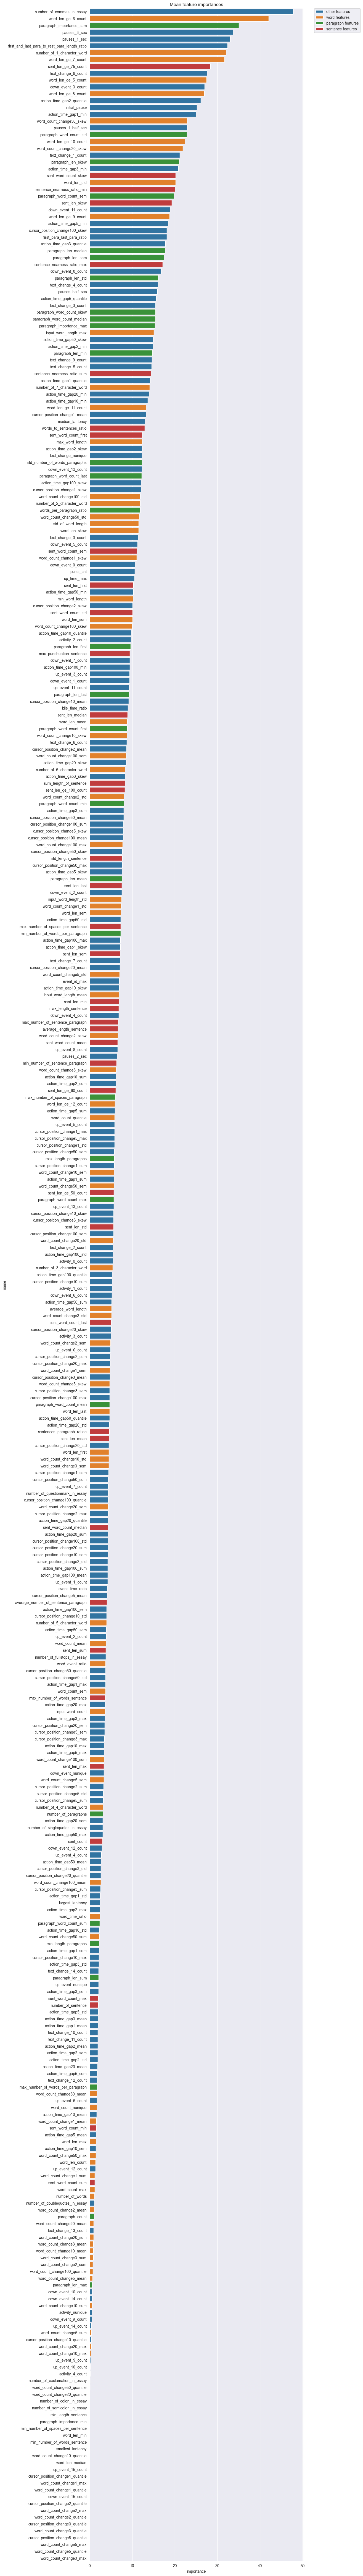

In [100]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_postprocessed_df.columns, 'importance': feature_importances_values})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df['group'] = feature_importance_df['name'].apply(
    lambda x: 'sentence features' if 'sent' in x else 'paragraph features' if 'paragraph' in x else 'word features' if 'word' in x else 'other features')

plt.figure(figsize=(10, 120))
ax = sns.barplot(data=feature_importance_df, x='importance', y='name', hue='group', dodge=False)
ax.set_title(f"Mean feature importances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [32]:
feature_importance_df

,name,importance,group
80,number_of_7_character_word,92.28,word features
47,number_of_commas_in_essay,52.02,other features
90,first_and_last_para_to_rest_para_length_ratio,49.32,other features
96,paragraph_importance_sum,46.48,paragraph features
65,sum_length_of_sentence,46.06,sentence features
...,...,...,...
125,word_count_change1_max,0.00,word features
322,up_event_15_count,0.00,other features
165,cursor_position_change3_quantile,0.00,other features
169,word_count_change3_max,0.00,word features


In [123]:
list(feature_importance_df[feature_importance_df["importance"] <=0]["name"])

['min_cursor_position',
 'cursor_position_change2_quantile',
 'cursor_position_change1_quantile',
 'up_event_15_count',
 'word_count_change1_quantile',
 'word_count_change3_quantile',
 'smallest_lantency',
 'cursor_position_change3_quantile',
 'down_event_15_count',
 'sum_Down_Numbers',
 'word_count_change2_quantile']

In [ ]:
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18}
params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }

lgb_model = lgb.LGBMRegressor(**params)

In [ ]:
cv_results = cross_val_score(lgb_model, train_postprocessed_df, y, cv=5, scoring='neg_mean_squared_error')


In [ ]:
cv_results

In [ ]:
#array([0.41127499, 0.36983201, 0.4229339 , 0.38716639, 0.41180781])

In [ ]:
# model = GradientBoostingRegressor(
#     n_estimators=300,
#     learning_rate=0.01,
#     max_depth=10,
#     min_samples_split=3,
#     min_samples_leaf=5,
#     subsample=0.9,
#     random_state=42
# )
model = RandomForestRegressor(
    n_estimators=3000,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

In [ ]:
results = performCrossValidation(model,train_postprocessed_df,train_logs_df,y,aggregation=True)

In [ ]:
results

In [ ]:
results

In [ ]:
model.fit(train_postprocessed_df,y)

In [ ]:
dataset_train = makePredictions(model,train_postprocessed_df,train_logs_df,aggregation=True)

In [ ]:
dataset_test = makePredictions(model,test_postprocessed_df,test_logs_df,aggregation=True) 

In [ ]:
mean_squared_error(y,dataset_train)

In [ ]:
# For submission
dataset_test["y_pred"].to_csv("submission.csv")

# Optimize with Optuna

In [139]:
def objective(trial):
    model,params = getModel("LGBMRegressor",optuna=True,trial=trial)
    # model,params = getModel("RandomForestRegressor",optuna=True,trial=trial)
    X_train, X_test, y_train, y_test = train_test_split(train_postprocessed_df, y, test_size=0.2,random_state=42)
    alpha = trial.suggest_float('alpha', 0.05, 0.1),
    e = trial.suggest_float('e', 0.05, 0.1), # You can adjust this value
    k = trial.suggest_float('k', 0.05, 0.1),  # You can adjust this value
    
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)
    learning_callbacks=lgb.reset_parameter(learning_rate=lambda current_round: alpha * e**(k * current_round))
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],callbacks=[early_stopping_callback, verbose_callback])
    # model.fit(X_train,y_train)

    preds = model.predict(X_test)

    rmse = mean_squared_error(y_test, preds,squared=False)

    return rmse
    

In [ ]:
from optuna.storages import RDBStorage
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=20),
    storage = "sqlite:///linking.db",
    study_name = "LGBMRegressor even more extra Features",
)
study.optimize(objective, n_trials=5000)